# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from celluloid import Camera
from random import random

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


## Data Loading and Visualization

Data from the [House Prices - Advanced Regression Techniques][1] Kaggle competiton.

[1]: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

In [2]:
data = pd.read_csv(
    'data/properties_prices.csv',
    usecols=['SalePrice','GrLivArea'])
data = data.sample(n=250, random_state=1)

In [3]:
X = data['GrLivArea']
Y = data['SalePrice']

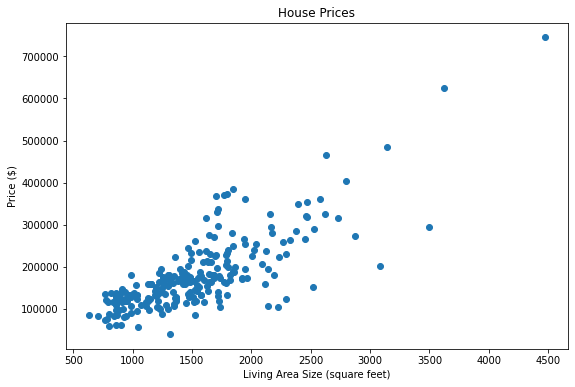

In [4]:
fig = plt.figure(figsize=(9,6))
plt.scatter(X, Y)
plt.title('House Prices')
plt.xlabel('Living Area Size (square feet)')
plt.ylabel('Price ($)')
plt.show()

## Linear Regression

In statistics, Linear Regression is a approach to modeling the relationship between a dependent variable ($y$) and one or more independent variables ($x$) by fitting a linear equation of the form $y = mx + b$ to the data where $m$ is the slope of the line, and $b$ is the intercept. 

In the case of Simple Linear Regression when there is a single dependent variable the coefficients, m and b, can be found by calculating statiscal properties such as means, standard deviations, etc. However, in real life problems we usually have to deal with multiple variables and thus finding the coefficients by just using statiscs is no longer practical.

## Cost Function

To find the unknown coefficients, we can use a Cost Function ($J$), which is a measure of how wrong the regression line fits the data. The Cost Function can be represented by an $error$ that it is defined as the difference between the observed value $y_{i}$ and the value predicted by the regression line ${y_{pred}}_{i}$:

$$
\begin{aligned}
error &= y_{i} - {y_{pred}}_{i} \\
 &= y_{i} - (mx_{i} + b)
\end{aligned}
$$

We'll use a method called Ordinary Least Squares as our Cost Function, this method estimates the coefficents, m and b, by minimizing the sum of the squared errors.

$$J = \frac{1}{n}\sum_{i = 0}^{n}(error_{i})^{2}$$

The following is the resulting Cost Function:

$$J(m,b) = \frac{1}{n}\sum_{i = 0}^{n}(y_{i} - (mx_{i} + b))^{2}$$

In [5]:
def calculate_cost(X, Y, m, b):
    n = len(Y)
    Y_pred = m * X + b
    error = Y - Y_pred
    
    # Cost function
    J = (1/n) * np.sum((error)**2)
    return J

## Gradient Descent

It's important to remember that our goal is precisely to minimize the cost function and to do so we'll use **Gradient Descent** an interative algorithm to find the mininum of a function.

$$\min_{(m,b)} J(m,b)$$

Gradient Descent is based on the observation that a function $F(x)$ decreases fastest if it goes from a point $a$ in the direction of the negative gradient at $a$, $-\nabla F(a)$. The gradient of a multi-variable function such as the cost function $J(m,b)$ can be calculated as follows:

$$
\nabla J(m,b) = \begin{bmatrix} 
\frac{\partial J}{\partial m}
\\ 
\frac{\partial J}{\partial b}
\end{bmatrix} = \begin{bmatrix}
\frac{1}{n}\sum_{i = 0}^{n}-2x_{i}(y_{i} - (mx_{i} + b))
\\ 
\frac{1}{n}\sum_{i = 0}^{n}-2(y_{i} - (mx_{i} + b))
\end{bmatrix}
$$

At every iteration the algorithm takes a small step in the opposite direction of the gradient by slightly updating the values of the coefficients:

$$
\begin{aligned}
m &{:=}  m -\gamma\frac{\partial}{\partial m}J(m,b) \\
b &{:=}  b -\gamma\frac{\partial}{\partial b}J(m,b)
\end{aligned}
$$

Here $\gamma$ is the **learning rate** which is basically the size of the step taken by the algorithm. If $\gamma$ is to small, Gradient Descent will converge slowly. Although, if $\gamma$ is too big Gradient Descent can overshoot the minimun and fail to converge.

In [6]:
def gradient_descent(X, Y, learning_rate, iter):
    # Inicialize slope(m) and intercept(b) with random numbers
    np.random.seed(10)
    m, b = np.random.rand(2)
    slopes, intercepts, costs = [], [], [] 
    for _ in range(iter):
        n = len(Y)
        Y_pred = m * X + b
        error = Y - Y_pred # Calculates the error
        
        # Calculate partial derivatives
        m_deriv = (-2/n) * np.sum(X * (error))
        b_deriv = (-2/n) * np.sum(error)
        
        # Update parameters values
        m -= m_deriv * learning_rate # Updating m
        b -= b_deriv * learning_rate # Updating b
        
        # Calculate the cost for the current iteration
        cost = calculate_cost(X, Y, m, b)
        
        # Store the values of the current iteration in the appropriate arrays
        slopes.append(m)
        intercepts.append(b)
        costs.append(cost)
    return slopes, intercepts, costs

## Visualizations

Below are some cool visualizations including 3d plots and animations.

In [7]:
import io
import base64
from IPython.display import HTML

def display_animation(file_name):
    video = io.open(file_name, 'r+b').read()
    encoded = base64.b64encode(video)
    html = HTML(
        data=
        f'''
        <img src="data:image/gif;base64,{encoded.decode('ascii')}" type="gif" />
        ''')
    return html

In [8]:
def get_3d_animation(X, Y, slopes, intercepts, iterations, output_file,
                     view_angle, n=250):
    fig = plt.figure(figsize=(12,5), dpi=500)

    # Setting up scatter plot
    ax1 = fig.add_subplot(121)
    ax1.set_title('House Prices')
    ax1.set_xlabel('Living Area Size (square feet)')
    ax1.set_ylabel('Price ($)')

    # Setting up 3d plot
    x = np.linspace(10, 230, n) 
    y = np.linspace(0.95*min(intercepts), 1.05*max(intercepts), n)
    M, B = np.meshgrid(x, y)
    z = np.array([calculate_cost(X, Y, m, b)
                  for m,b 
                  in zip(np.ravel(M), np.ravel(B))])
    J = z.reshape(M.shape)
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_xlabel(r'$Slope$', fontsize=15)
    ax2.set_ylabel(r'$Intercept$', fontsize=15)
    ax2.zaxis.set_rotate_label(False)
    ax2.set_zlabel(r'$Cost$', fontsize=15, rotation=0, labelpad=10)
    ax2.view_init(20, view_angle)
    plt.close()
    
    X_max = max(X)
    x_ = np.linspace(0, int(1.05*X_max), 10000)

    camera = Camera(fig)
    for i in range(iterations):
        # Scatter plot of training data
        ax1.scatter(X, Y,  c='C0', marker='.') 
        # Regression line
        y_ = slopes[i] * x_ + intercepts[i]
        ax1.plot(x_, y_, lw=1.5, color='red') 
        # Cost function 3d animation
        ax2.plot_surface(M, B, J, rstride=5, cstride=5,
                         cmap='jet', alpha=0.5)
        ax2.plot(slopes[:i], intercepts[:i],
                 costs[:i], 'k', marker='.') 

        camera.snap()

    animation = camera.animate()
    animation.save(output_file)

In [9]:
def plot_cost_function(costs):
    fig = plt.figure(figsize=(6,4))
    plt.title('Cost Function (J)')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.plot(costs)
    plt.show()

## Effects of the learning rate

To illustrate the effects of the learning rate on the convergence of a Gradient Descent Algorithm we will fit two regression lines to the data. In the first one, we will use a very small learning rate and in the second, a rate nine times higher.

### Low Learning Rate

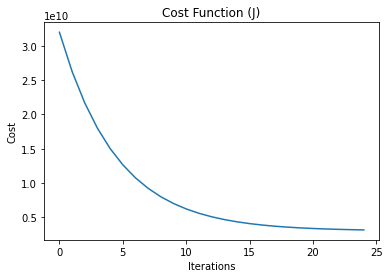

In [10]:
learning_rate = 2e-8
iterations = 25
slopes, intercepts, costs = gradient_descent(X, Y, learning_rate, iterations)
plot_cost_function(costs)

With a small learning rate we can observe that the cost function converges slowly.


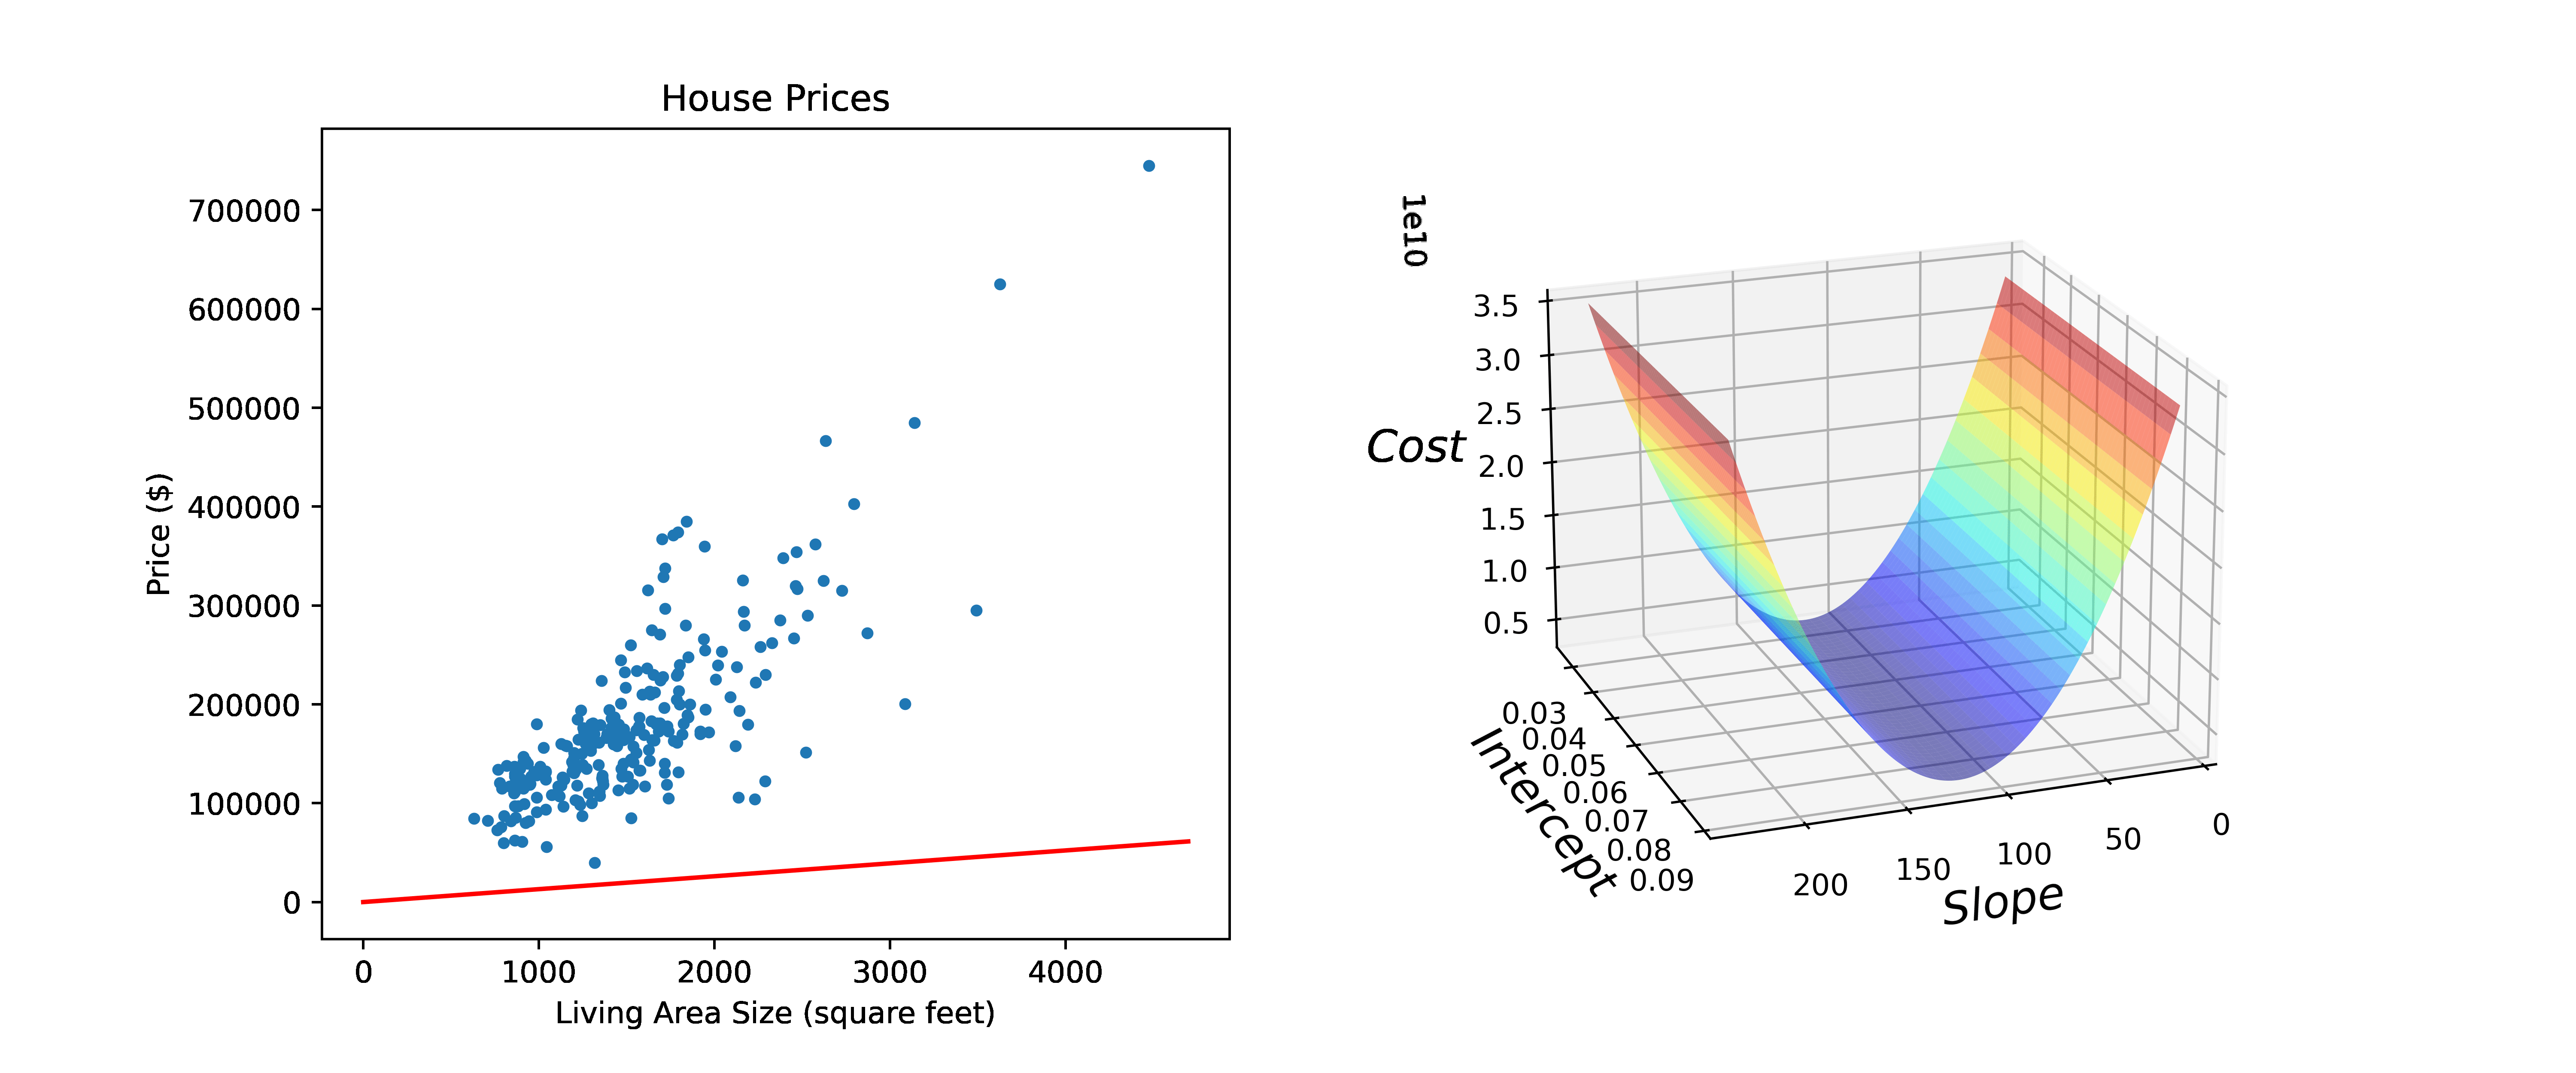

In [11]:
file_name = 'gifs/linear_regression_low_lr.gif'
view_angle = 70
get_3d_animation(X, Y, slopes, intercepts,
                 iterations, file_name, view_angle)
display_animation(file_name)

### High Learning Rate

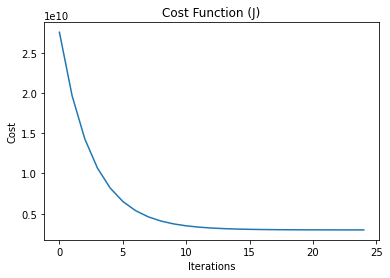

In [12]:
learning_rate = 3.5e-7
iterations = 25
slopes, intercepts, costs = gradient_descent(X, Y, learning_rate, iterations)
plot_cost_function(costs)

However, with a higher learning rate, the step is bigger and the algorithm overshoots the minimum multiple times until it converges.


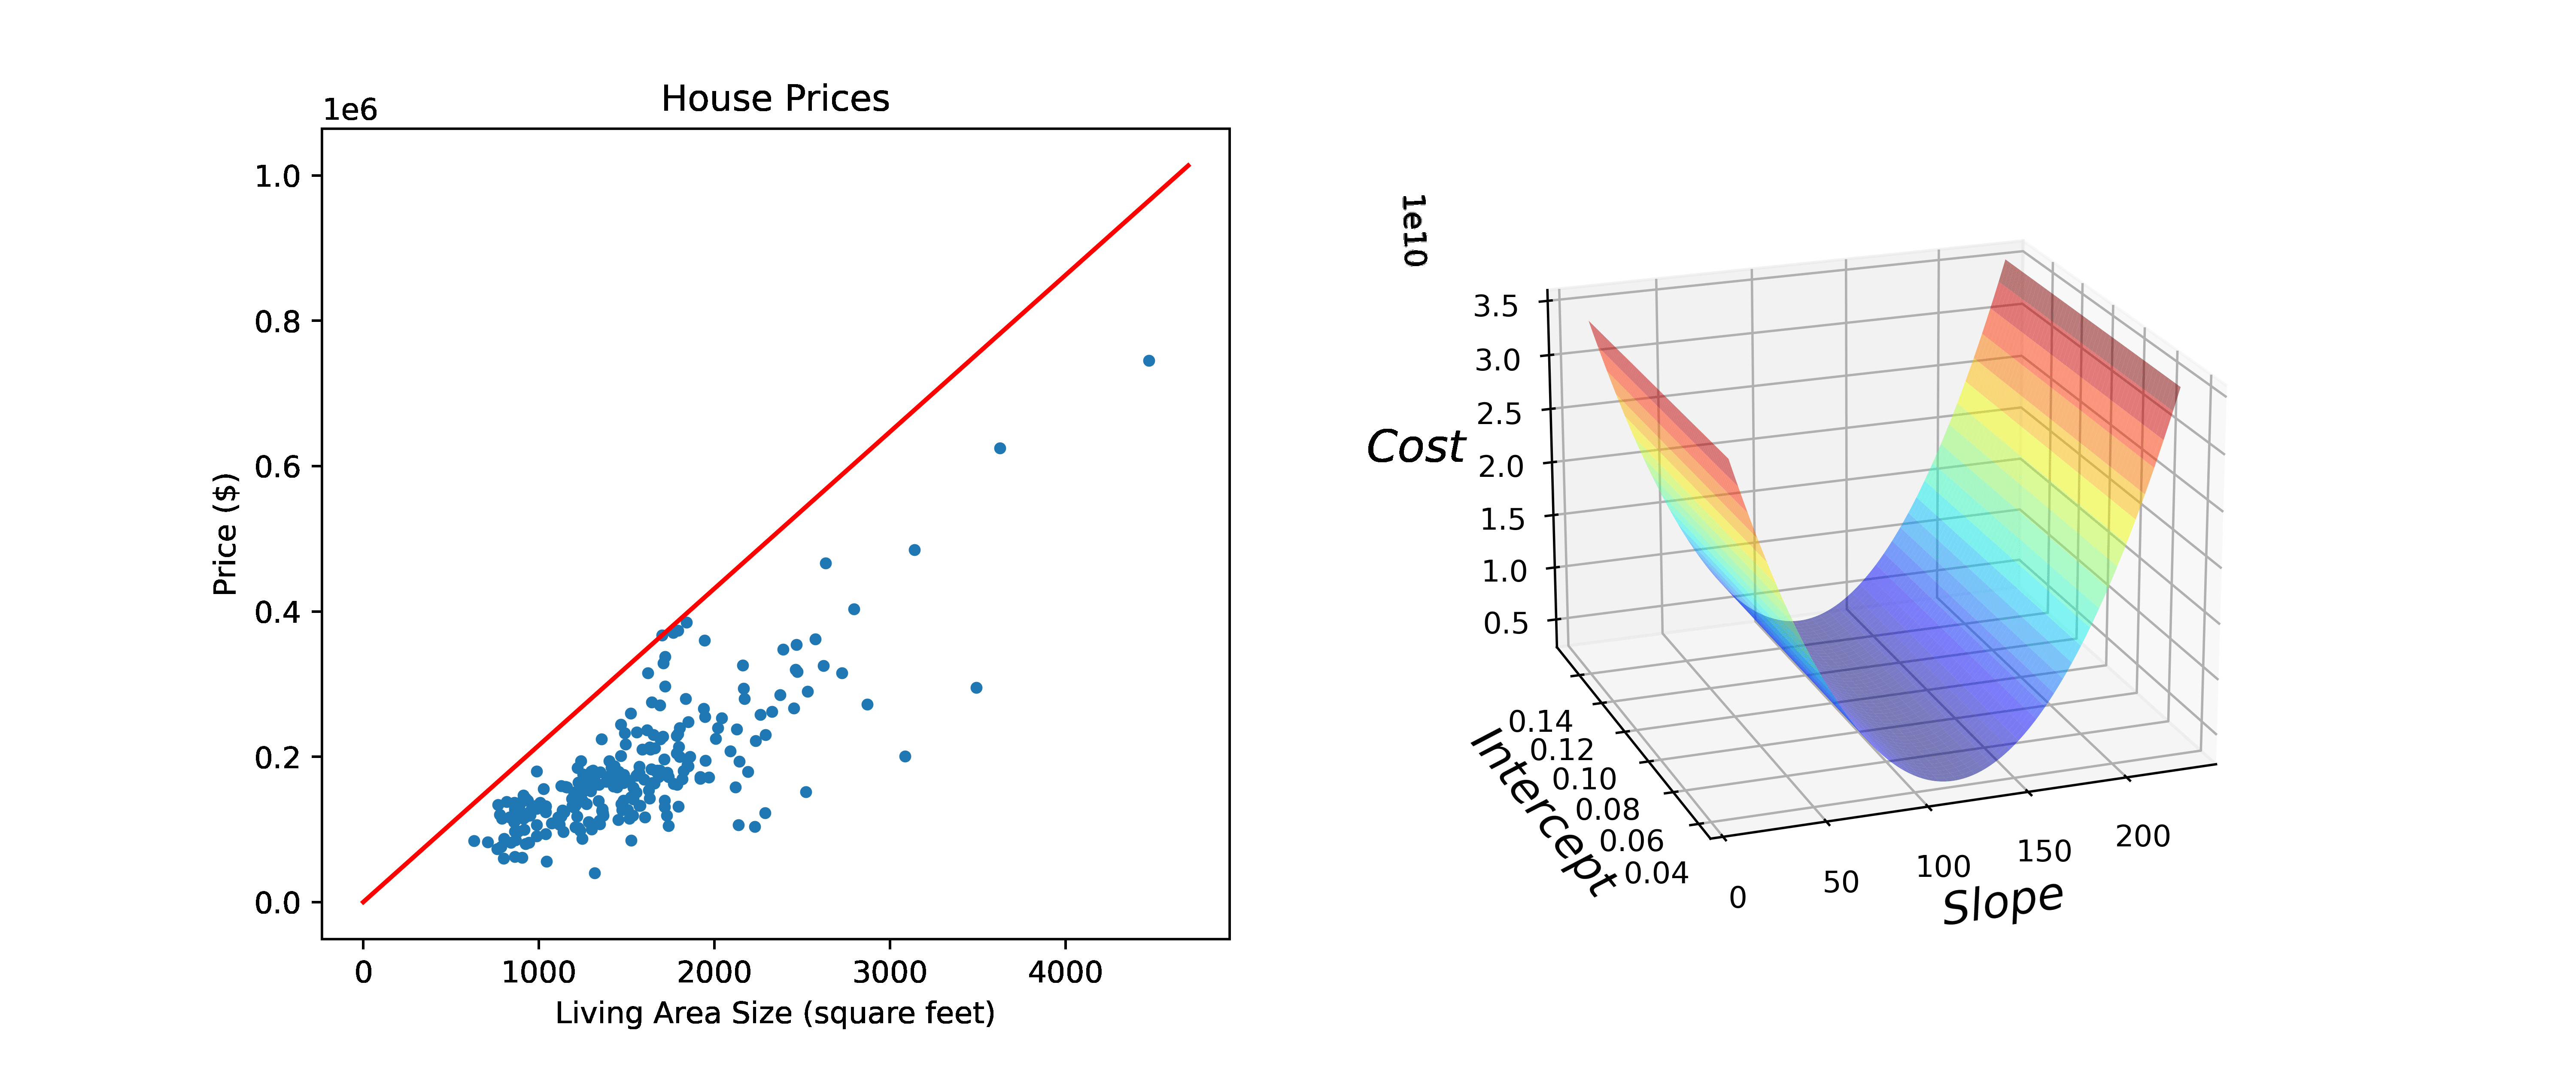

In [13]:
file_name = 'gifs/linear_regression_high_lr.gif'
get_3d_animation(X, Y, slopes, intercepts,
                 iterations, file_name, view_angle + 180)
display_animation(file_name)